In [1]:
# Import modules
import os
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt

from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet

from sklearn.ensemble import RandomForestRegressor

from sklearn.feature_selection import SelectKBest, f_regression

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from sklearn.pipeline import make_pipeline

import warnings

import time

today = dt.date.today()
this_month = pd.to_datetime(str(today.year)+'-'+str(today.month)+'-01')

%matplotlib inline

%qtconsole

In [2]:
# Define local directories
master_dir = 'C:\\Users\\Bryan\\OneDrive\\02 GitHub\\rig-count_L48\\'
data_raw_dir = 'C:\\Users\\Bryan\\OneDrive\\02 GitHub\\rig-count_L48\\data\\raw\\'
data_interim_dir = 'C:\\Users\\Bryan\\OneDrive\\02 GitHub\\rig-count_L48\\data\\interim\\'
data_processed_dir = 'C:\\Users\\Bryan\\OneDrive\\02 GitHub\\rig-count_L48\\data\\processed\\'
data_external_dir = 'C:\\Users\\Bryan\\OneDrive\\02 GitHub\\rig-count_L48\\data\\external\\'

In [3]:
df = pd.read_csv(data_processed_dir+'processed_data-TSF.csv')
df.date = pd.to_datetime(df.date)
df = df.sort_values(by='date', ascending=True)
df = df[df.date > '2016-06'].reset_index(drop=True)
df.head(2)

,date,Total US RigCount,wti_spot_lag_14__benford_correlation,oecd_cons_smooth__benford_correlation,wti_fut_4__benford_correlation,wti_spot__benford_correlation,usa_net_import__benford_correlation,opec_surp_capac__range_count__max_1__min_-1,usa_l48_prod__abs_energy,brent_spot__benford_correlation,opec_surp_capac__abs_energy,wti_spot_lag_14,brent_spot,usa_net_import,usa_l48_prod,opec_surp_capac
0,2016-06-03,325.0,0.062915,0.062915,-0.14528,-0.064614,-0.24169,0.0,67.519089,-0.064614,1.084376,31.322,48.905,7.216,8.217,1.041334
1,2016-06-10,328.0,0.062915,0.062915,-0.14528,-0.145280,-0.24169,0.0,67.059721,-0.064614,1.022124,34.434,49.944,7.133,8.189,1.011001


In [4]:
# Remove wti_spot, brent_spot for redundant values with wti_spot_lag_14
df = df.drop(['usa_l48_prod','usa_net_import'],axis=1)

# Noticed significant variation in early models that were not present in the majority of the data. 
# SelectKBest ended up adding much more significance to the world_cons data and caused modeling
# issues with MinMaxScaler... Same issues existed with StandardScaler

#df = df.drop['world_cons','oecd_cons','non-oecd_cons','usa_net_import','usa_l48_prod','wti_fut_1','wti_fut_2','wti_fut_3','wti_fut_4'],axis=1)

df.head(2)

,date,Total US RigCount,wti_spot_lag_14__benford_correlation,oecd_cons_smooth__benford_correlation,wti_fut_4__benford_correlation,wti_spot__benford_correlation,usa_net_import__benford_correlation,opec_surp_capac__range_count__max_1__min_-1,usa_l48_prod__abs_energy,brent_spot__benford_correlation,opec_surp_capac__abs_energy,wti_spot_lag_14,brent_spot,usa_net_import,opec_surp_capac
0,2016-06-03,325.0,0.062915,0.062915,-0.14528,-0.064614,-0.24169,0.0,67.519089,-0.064614,1.084376,31.322,48.905,7.216,1.041334
1,2016-06-10,328.0,0.062915,0.062915,-0.14528,-0.145280,-0.24169,0.0,67.059721,-0.064614,1.022124,34.434,49.944,7.133,1.011001


In [5]:
df.shape

(226, 15)

## Train Test Split
Define features X, and target variable y

In [6]:
X = df.iloc[:,2:]
y = df.iloc[:,1]

date = df.date

model_score = pd.DataFrame(columns=['model','rmse_tr','r2_tr','mae_tr','rmse_tt','r2_tt','mae_tt'])

In [7]:
# Define functions
def plot_model(date,X,y,ts_cv,pipe,plot=True):

    mse_tt = []
    r2_tt = []
    mae_tt = []
    
    mse_tr = []
    r2_tr = []
    mae_tr = []
    
    if plot == True:
        fig, ax = plt.subplots(2, sharex=True, figsize=(18,10))
        ax[0].plot(date,y)
        ax[1].plot(date,y)
        ax[1].xaxis.set_major_locator(matplotlib.dates.MonthLocator(bymonth = range(0,13,6)))
        ax[1].xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%Y-%m"))
        

        for ii, (tr, tt) in enumerate(ts_cv.split(X,y)):
            X_tr = X.iloc[tr,:]
            y_tr = y.iloc[tr]
            X_tt = X.iloc[tt,:]
            y_tt = y.iloc[tt]
            pipe.fit(X_tr,y_tr)

            # Training data scores
            y_tr_pred = pipe.predict(X_tr)
            
            mse_tr.append(mean_squared_error(y_tr_pred,y_tr,squared=False))
            r2_tr.append(r2_score(y_tr_pred,y_tr))
            mae_tr.append(mean_absolute_error(y_tr_pred,y_tr))
            
            ax[0].plot(date[tr],y_tr_pred, label='train iter no'+str(ii+1))
            #ax[0].legend()
            
            #Testing data scores
            y_tt_pred = pipe.predict(X_tt)
            
            mse_tt.append(mean_squared_error(y_tt_pred,y_tt,squared=False))
            r2_tt.append(r2_score(y_tt_pred,y_tt))
            mae_tt.append(mean_absolute_error(y_tt_pred,y_tt))
            
            ax[1].plot(date[tt],y_tt_pred, label='test iter no '+str(ii+1),)
            #ax[1].legend()
            
        plt.xticks(rotation=75)
        plt.show()

    else:
        
        for ii, (tr, tt) in enumerate(ts_cv.split(X,y)):
            X_tr = X.iloc[tr,:]
            y_tr = y.iloc[tr]
            X_tt = X.iloc[tt,:]
            y_tt = y.iloc[tt]
            pipe.fit(X_tr,y_tr)

            # Training data scores
            y_tr_pred = pipe.predict(X_tr)
            
            mse_tr.append(mean_squared_error(y_tr_pred,y_tr,squared=False))
            r2_tr.append(r2_score(y_tr_pred,y_tr))
            mae_tr.append(mean_absolute_error(y_tr_pred,y_tr))
            
            #Testing data scores
            y_tt_pred = pipe.predict(X_tt)
            
            mse_tt.append(mean_squared_error(y_tt_pred,y_tt,squared=False))
            r2_tt.append(r2_score(y_tt_pred,y_tt))
            mae_tt.append(mean_absolute_error(y_tt_pred,y_tt))
            
    return np.mean(mse_tr), np.mean(r2_tr), np.mean(mae_tr), np.mean(mse_tt), np.mean(r2_tt), np.mean(mae_tt),

def add_model(model, errors):
    
    global model_score
    
    rmse_tr, r2_tr, mae_tr, rmse_tt, r2_tt, mae_tt = errors
    
    row = {
        'model':model,
        'rmse_tr':rmse_tr,
        'r2_tr':r2_tr,
        'mae_tr':mae_tr, 
        'rmse_tt':rmse_tt,
        'r2_tt':r2_tt,
        'mae_tt':mae_tt, 
    }
    
    model_score = model_score.append(row,ignore_index=True)
    
    return errors

### Linear Regression 
Baseline model will be a linear regression with all features.

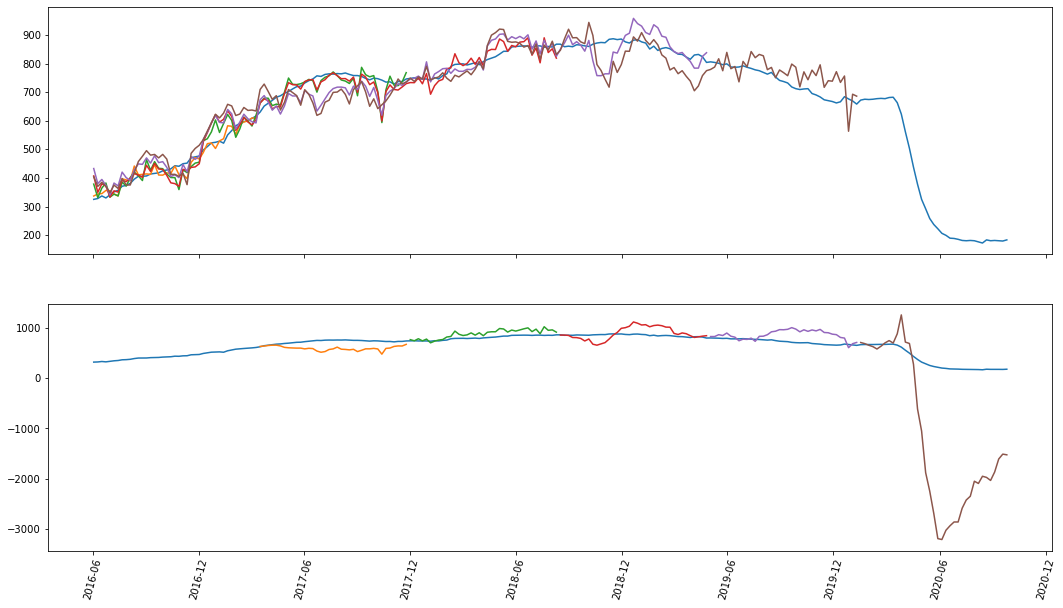

(38.56775482420005,
 0.9204683387808485,
 29.906705674813402,
 502.6642793918477,
 -2.937522752526316,
 400.988428262802)

In [8]:
# Baseline linear regression with no additional features
n_splits = 5

model = LinearRegression()
cv = TimeSeriesSplit(n_splits=n_splits)
pipe = make_pipeline(model)

lin_base = plot_model(date,X,y,cv,pipe)
add_model('linear_base',lin_base)

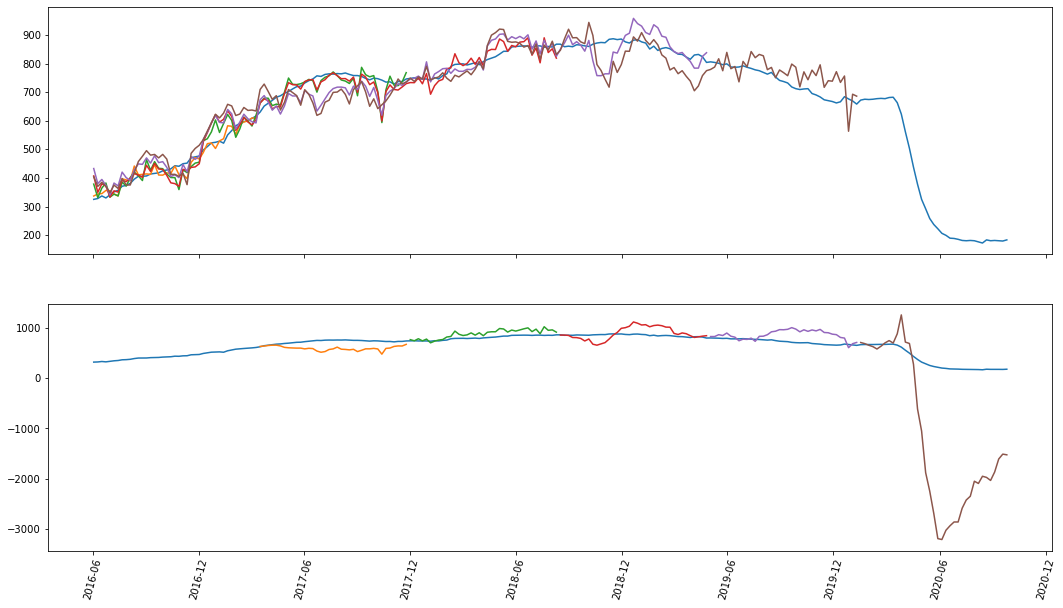

(38.56775482420006,
 0.920468338780849,
 29.906705674813292,
 502.66427939184723,
 -2.9375227525263634,
 400.9884282628019)

In [9]:
# Add scaler to features
scaler = StandardScaler()
pipe = make_pipeline(scaler,model)

lin_scal = plot_model(date,X,y,cv,pipe)
add_model('linear_scaled',lin_scal)

In [10]:
# Let's try with rolling window for the time series to account for the data being non-stationary

max_train_score = pd.DataFrame(columns=['n_splits','train_size','rmse_tr','r2_tr','mae_tr','rmse_tt','r2_tt','mae_tt'])

warnings.filterwarnings('ignore')

start_time = time.time()

for n in np.arange(5,50,step=5):
    for i in np.arange(10,df.shape[0],step =10):
        cv = TimeSeriesSplit(n_splits=n,max_train_size=i)

        rmse_tr, r2_tr, mae_tr, rmse_tt, r2_tt, mae_tt = plot_model(date,X,y,cv,pipe,plot=False)

        row = {
            'n_splits':n,
            'train_size':i,
            'rmse_tr':rmse_tr,
            'r2_tr':r2_tr,
            'mae_tr':mae_tr, 
            'rmse_tt':rmse_tt,
            'r2_tt':r2_tt,
            'mae_tt':mae_tt, 
        }

        max_train_score = max_train_score.append(row,ignore_index=True)

print('Cell took '+time.strftime('%H:%M:%S',time.gmtime(time.time()-start_time))+' long to run.')
        
warnings.filterwarnings('default')  
    
max_train_score.sort_values(by='rmse_tt', inplace=True)
max_train_score.head()

Cell took 00:01:05 long to run.


,n_splits,train_size,rmse_tr,r2_tr,mae_tr,rmse_tt,r2_tt,mae_tt
180,45.0,50.0,16.842102,0.884592,12.967285,59.935784,-38.101722,50.192728
183,45.0,80.0,24.863749,0.878118,18.927451,66.815924,-35.929922,58.356256
182,45.0,70.0,22.826940,0.887889,17.397236,68.830243,-17.686200,59.982273
136,35.0,50.0,16.410841,0.887584,12.593280,71.878001,-14.031773,58.768368
181,45.0,60.0,20.346249,0.886815,15.461814,73.801945,-19.135786,63.140788


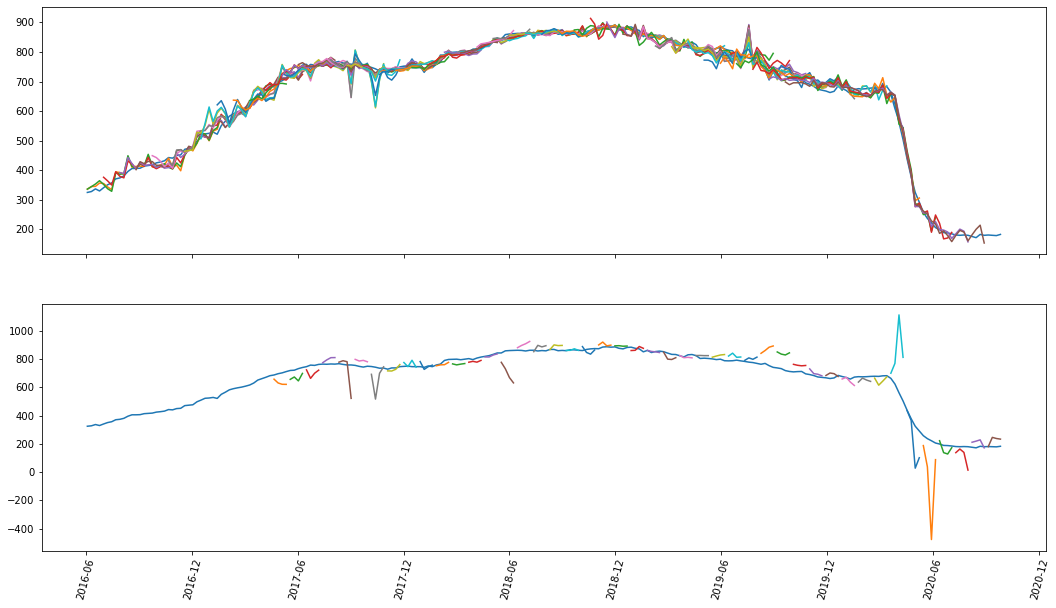

(16.842101751006524,
 0.8845919576534922,
 12.967284982812275,
 59.93578365451996,
 -38.10172223296408,
 50.19272763606551)

In [11]:
max_train_best = int(max_train_score.train_size[max_train_score.index[0]])
n_splits_best = int(max_train_score.n_splits[max_train_score.index[0]])

cv = TimeSeriesSplit(n_splits=n_splits_best,max_train_size=max_train_best)

plot_model(date,X,y,cv,pipe)

In [12]:
# Parameter tuning for SelectKBest - manual
k_score = pd.DataFrame(columns=['k','rmse_tr','r2_tr','mae_tr','rmse_tt','r2_tt','mae_tt'])

warnings.filterwarnings('ignore')  

start_time = time.time()

for i in np.arange(1,X.shape[1]+1):
    feat_sel = SelectKBest(f_regression,k=i)
    pipe = make_pipeline(scaler,feat_sel,model)
  
    rmse_tr, r2_tr, mae_tr, rmse_tt, r2_tt, mae_tt = plot_model(date,X,y,cv,pipe,plot=False)
    
    new_row = {
        'k':i,
        'rmse_tr':rmse_tr,
        'r2_tr':r2_tr,
        'mae_tr':mae_tr, 
        'rmse_tt':rmse_tt,
        'r2_tt':r2_tt,
        'mae_tt':mae_tt, 
    }
        
    k_score = k_score.append(new_row,ignore_index=True)

print('Cell took '+time.strftime('%H:%M:%S',time.gmtime(time.time()-start_time))+' long to run.')
    
warnings.filterwarnings('default') 

Cell took 00:00:07 long to run.


In [13]:
k_score.sort_values(by='rmse_tt',inplace=True)
k_score.head()

,k,rmse_tr,r2_tr,mae_tr,rmse_tt,r2_tt,mae_tt
2,3.0,24.737043,0.728074,18.228015,45.828265,-143.691569,40.815190
3,4.0,23.516027,0.762165,17.284599,47.430819,-989.737727,41.953164
1,2.0,26.374250,0.697693,19.461857,48.929168,-773.068504,44.479736
4,5.0,22.797145,0.775413,16.888394,49.150102,-60.425527,43.474206
5,6.0,20.781433,0.817795,15.772256,50.251933,-53.627080,44.799675


C:\Users\bryan\Anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\bryan\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
C:\Users\bryan\Anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\bryan\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
C:\Users\bryan\Anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\bryan\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_eq

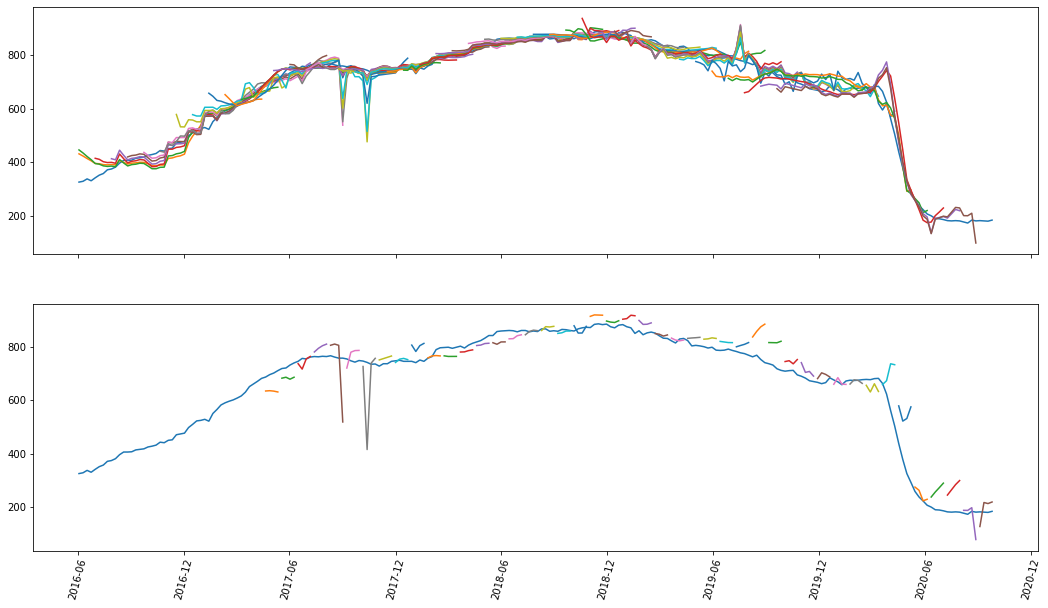

(24.73704289102426,
 0.7280736287283446,
 18.228015238156583,
 45.82826545093466,
 -143.69156922548194,
 40.815189998716875)

In [14]:
k_best = int(k_score.k[k_score.index[0]])

feat_sel = SelectKBest(f_regression,k=k_best)
pipe = make_pipeline(scaler,feat_sel,model)

lin_kbest = plot_model(date,X,y,cv,pipe)
add_model('linear_kbest',lin_kbest)

In [15]:
pd.Series(model.coef_, index=X.columns[feat_sel.get_support()]).sort_values(ascending=False)

usa_l48_prod__abs_energy        93.903051
opec_surp_capac__abs_energy     71.709049
opec_surp_capac               -204.320435
dtype: float64

C:\Users\bryan\Anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\bryan\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
C:\Users\bryan\Anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\bryan\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
C:\Users\bryan\Anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\bryan\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_eq

C:\Users\bryan\Anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\bryan\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


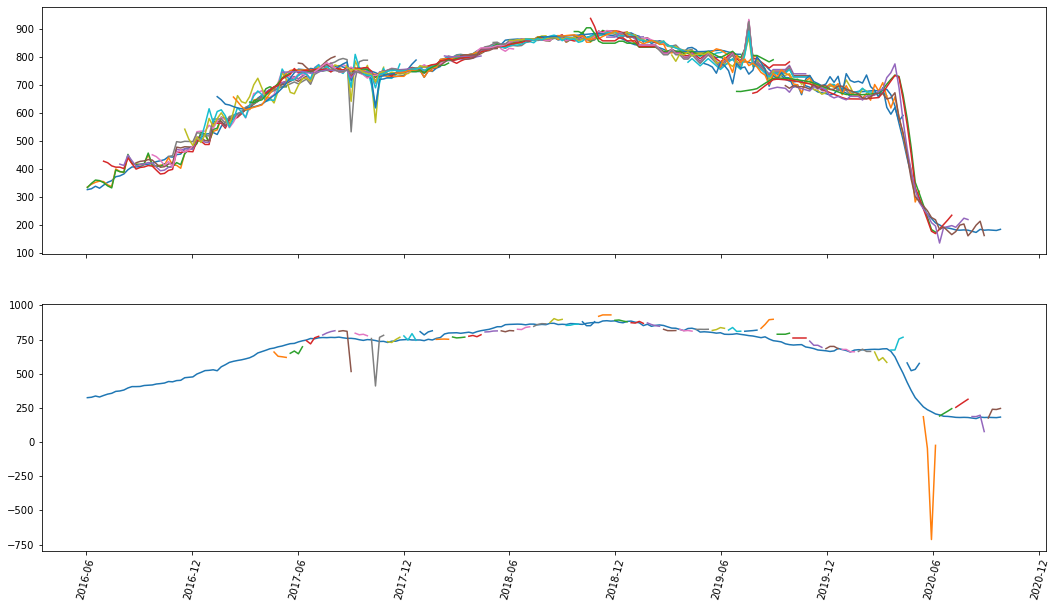

(22.17921061640686,
 0.7930406542628244,
 16.44466296962017,
 58.26516160967473,
 -89.3938743542016,
 50.07719589200666)

In [16]:
# Parameter tuning for linear regression - GridSearchCV
feat_sel = SelectKBest(f_regression,k='all')
pipe = make_pipeline(scaler,feat_sel,model)

param_grid = {'selectkbest__k':np.arange(1,X.shape[1]+1)}

gs_cv = GridSearchCV(pipe,param_grid=param_grid,n_jobs=-1)

lin_cv_kbest = plot_model(date,X,y,cv,gs_cv)
lin_cv_kbest

In [17]:
selected = gs_cv.best_estimator_.named_steps.selectkbest.get_support()
coefs = gs_cv.best_estimator_.named_steps.linearregression.coef_
features = pd.Series(coefs, index=X.columns[selected]).sort_values(ascending=False)

print(gs_cv.best_params_)
print(features)

{'selectkbest__k': 9}
usa_l48_prod__abs_energy                  59.224377
brent_spot                                46.474796
wti_spot_lag_14                           38.486920
opec_surp_capac__abs_energy               18.951575
wti_fut_4__benford_correlation            10.461313
oecd_cons_smooth__benford_correlation      0.026768
wti_spot_lag_14__benford_correlation      -0.335295
brent_spot__benford_correlation           -4.770452
opec_surp_capac                         -136.444162
dtype: float64


### Ridge Regression 
Baseline model will be a ridge regression with default alpha.

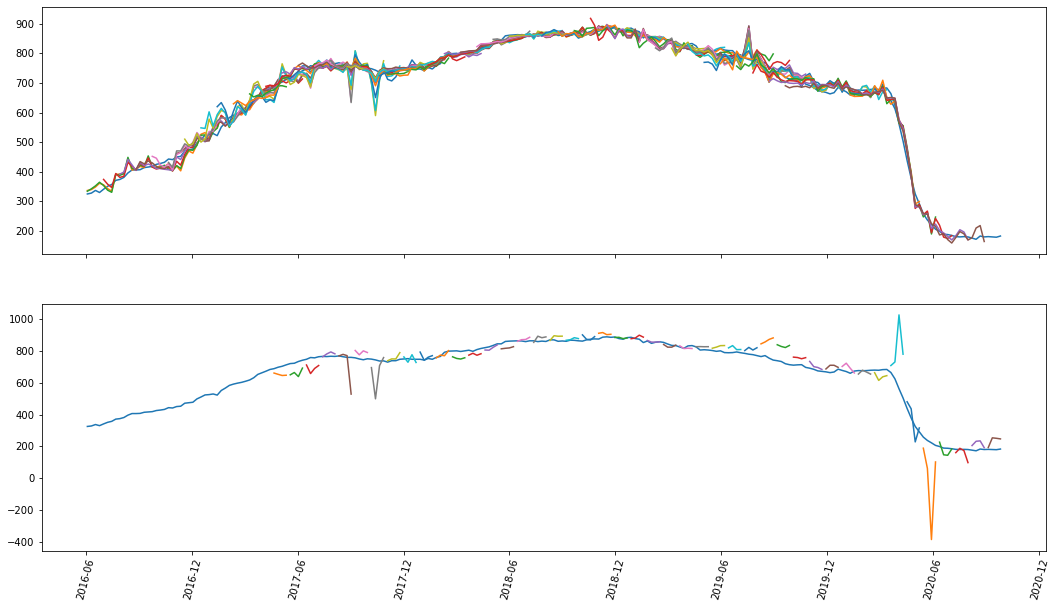

(17.76391095073354,
 0.8640104661122344,
 13.669608241629758,
 50.03720317859782,
 -99.14805487230383,
 42.41863103637377)

In [18]:
model = Ridge()
pipe = make_pipeline(scaler,model)

ridge_base = plot_model(date,X,y,cv,pipe)
add_model('ridge_base',ridge_base)

In [19]:
alpha_score = pd.DataFrame(columns=['alpha','rmse_tr','r2_tr','mae_tr','rmse_tt','r2_tt','mae_tt'])

warnings.filterwarnings('ignore')

for j in np.arange(0.001,0.5,step=0.005):
    model = Ridge(alpha=j)
    pipe = make_pipeline(scaler,model)
  
    rmse_tr, r2_tr, mae_tr, rmse_tt, r2_tt, mae_tt = plot_model(date,X,y,cv,pipe,plot=False)
    
    new_row = {
        'alpha':j,
        'rmse_tr':rmse_tr,
        'r2_tr':r2_tr,
        'mae_tr':mae_tr, 
        'rmse_tt':rmse_tt,
        'r2_tt':r2_tt,
        'mae_tt':mae_tt, 
    }
        
    alpha_score = alpha_score.append(new_row,ignore_index=True)

warnings.filterwarnings('default')  
    
alpha_score.sort_values(by='rmse_tt',inplace=True)
alpha_score.head()

,alpha,rmse_tr,r2_tr,mae_tr,rmse_tt,r2_tt,mae_tt
99,0.496,17.544490,0.868813,13.509175,51.739772,-67.046083,43.767440
98,0.491,17.541946,0.868867,13.507341,51.760989,-66.764294,43.782807
97,0.486,17.539388,0.868922,13.505503,51.782319,-66.483275,43.798175
96,0.481,17.536814,0.868977,13.503654,51.803764,-66.203022,43.813542
95,0.476,17.534225,0.869032,13.501792,51.825325,-65.923533,43.828908


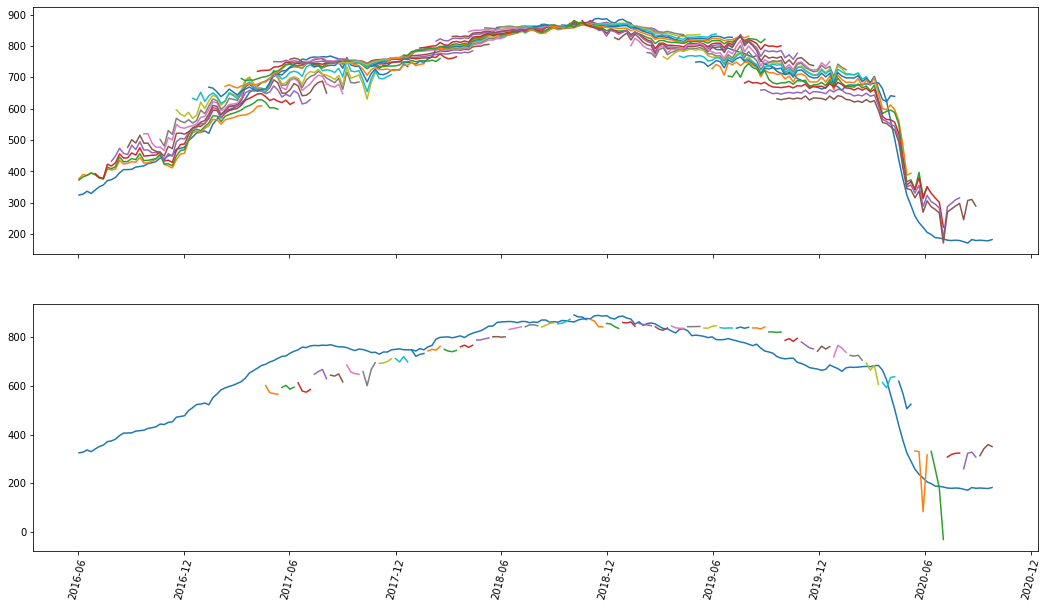

(33.54266516900984,
 -0.0863320624876924,
 27.431955035526162,
 68.9729445397162,
 -717.8469307663684,
 66.61637156023228)

In [20]:
alpha_best = alpha_score.index[0]
model = Ridge(alpha=alpha_best)
pipe = make_pipeline(scaler,model)

ridge_alpha = plot_model(date,X,y,cv,pipe)
add_model('ridge_alpha',ridge_alpha)

In [21]:
ak_score = pd.DataFrame(columns=['k','alpha','rmse_tr','r2_tr','mae_tr','rmse_tt','r2_tt','mae_tt'])

warnings.filterwarnings('ignore')

for i in range(2,X.shape[1]+1):
    feat_sel = SelectKBest(f_regression,k=i)
    
    for j in np.arange(0.1,0.5,step=0.001):
        model = Ridge(alpha=j)
        pipe = make_pipeline(scaler,feat_sel,model)
  
        rmse_tr, r2_tr, mae_tr, rmse_tt, r2_tt, mae_tt = plot_model(date,X,y,cv,pipe,plot=False)

        new_row = {
            'k':i,
            'alpha':j,
            'rmse_tr':rmse_tr,
            'r2_tr':r2_tr,
            'mae_tr':mae_tr, 
            'rmse_tt':rmse_tt,
            'r2_tt':r2_tt,
            'mae_tt':mae_tt, 
        }
        
        ak_score = ak_score.append(new_row,ignore_index=True)
        
warnings.filterwarnings('default')    

ak_score.sort_values(by='rmse_tt',inplace=True)
ak_score.head()

,k,alpha,rmse_tr,r2_tr,mae_tr,rmse_tt,r2_tt,mae_tt
400,3.0,0.100,25.008176,0.715123,18.535819,46.151488,-137.725315,41.504115
401,3.0,0.101,25.009429,0.715063,18.537112,46.153066,-138.015926,41.507359
402,3.0,0.102,25.010671,0.715004,18.538392,46.154631,-138.310798,41.510572
403,3.0,0.103,25.011904,0.714946,18.539659,46.156182,-138.609950,41.513755
404,3.0,0.104,25.013126,0.714888,18.540913,46.157719,-138.913403,41.516908


C:\Users\bryan\Anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\bryan\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
C:\Users\bryan\Anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\bryan\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
C:\Users\bryan\Anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\bryan\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_eq

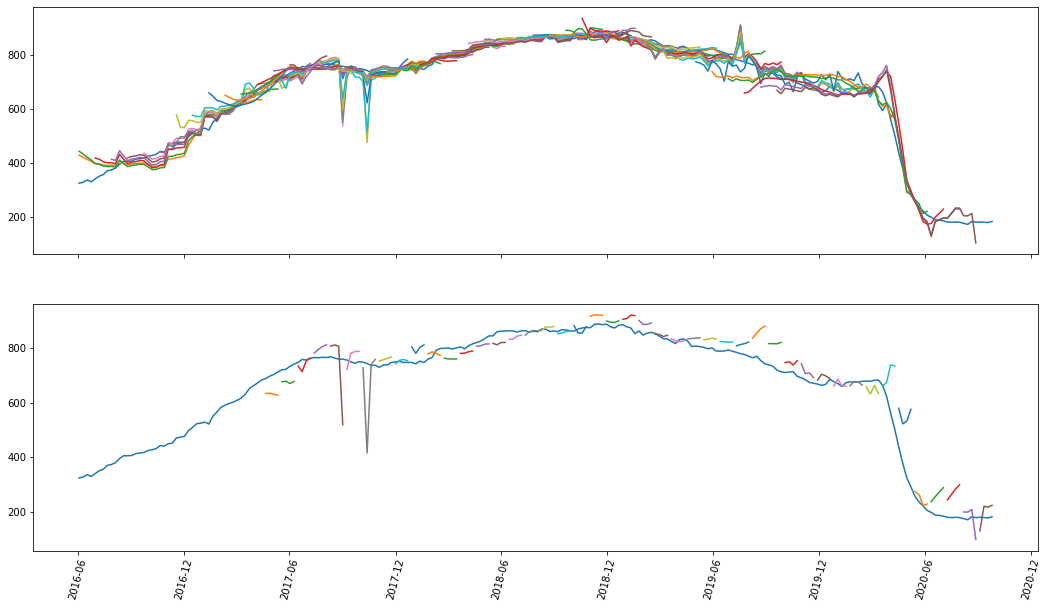

(25.008175562399554,
 0.7151228202218314,
 18.53581875890012,
 46.1514875481658,
 -137.72531534537418,
 41.504115111319436)

In [22]:
alpha_best = ak_score.alpha[ak_score.index[0]]
k_best = int(ak_score.k[ak_score.index[0]])

model = Ridge(alpha=alpha_best)
feat_sel = SelectKBest(f_regression,k=k_best)
pipe = make_pipeline(scaler,feat_sel,model)

ridge_ak = plot_model(date,X,y,cv,pipe)
add_model('ridge_ak',ridge_ak)

In [23]:
print(pd.Series(model.coef_, index=X.columns[feat_sel.get_support()]).sort_values(ascending=False))

usa_l48_prod__abs_energy        92.618894
opec_surp_capac__abs_energy     37.968777
opec_surp_capac               -171.602821
dtype: float64


### Lasso Regression 
Baseline model will be a lasso regression with no alpha optimisation.

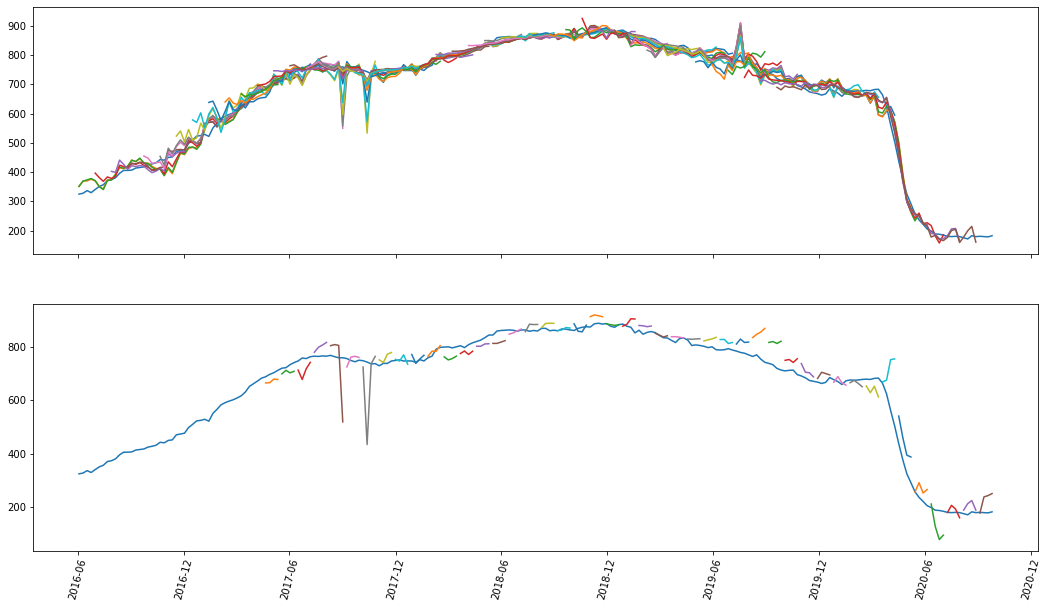

(20.571569008338066,
 0.8098177693459402,
 15.175057939593325,
 39.83487384515727,
 -54.703507213066516,
 34.67465157793842)

In [24]:
model = Lasso()
pipe = make_pipeline(scaler,model)

lasso_base = plot_model(date,X,y,cv,model)
add_model('lasso_base',lasso_base)

In [25]:
alpha_score = pd.DataFrame(columns=['alpha','rmse_tr','r2_tr','mae_tr','rmse_tt','r2_tt','mae_tt'])

for j in np.arange(0.75,2,step=0.005):
    model = Lasso(alpha=j)
    pipe = make_pipeline(scaler,model)
  
    rmse_tr, r2_tr, mae_tr, rmse_tt, r2_tt, mae_tt = plot_model(date,X,y,cv,pipe,plot=False)
    
    new_row = {
        'alpha':j,
        'rmse_tr':rmse_tr,
        'r2_tr':r2_tr,
        'mae_tr':mae_tr, 
        'rmse_tt':rmse_tt,
        'r2_tt':r2_tt,
        'mae_tt':mae_tt, 
    }

    alpha_score = alpha_score.append(new_row,ignore_index=True)
    
alpha_score.sort_values(by='rmse_tt',inplace=True)
alpha_score.head()

,alpha,rmse_tr,r2_tr,mae_tr,rmse_tt,r2_tt,mae_tt
157,1.535,18.907405,0.813345,14.440314,47.238322,-95.610354,40.490606
156,1.530,18.903081,0.813567,14.437145,47.240813,-95.500933,40.496010
158,1.540,18.911592,0.813125,14.443407,47.242651,-95.728494,40.492065
155,1.525,18.898750,0.813789,14.433946,47.244271,-95.391118,40.502273
159,1.545,18.915799,0.812902,14.446504,47.246523,-95.837256,40.492902


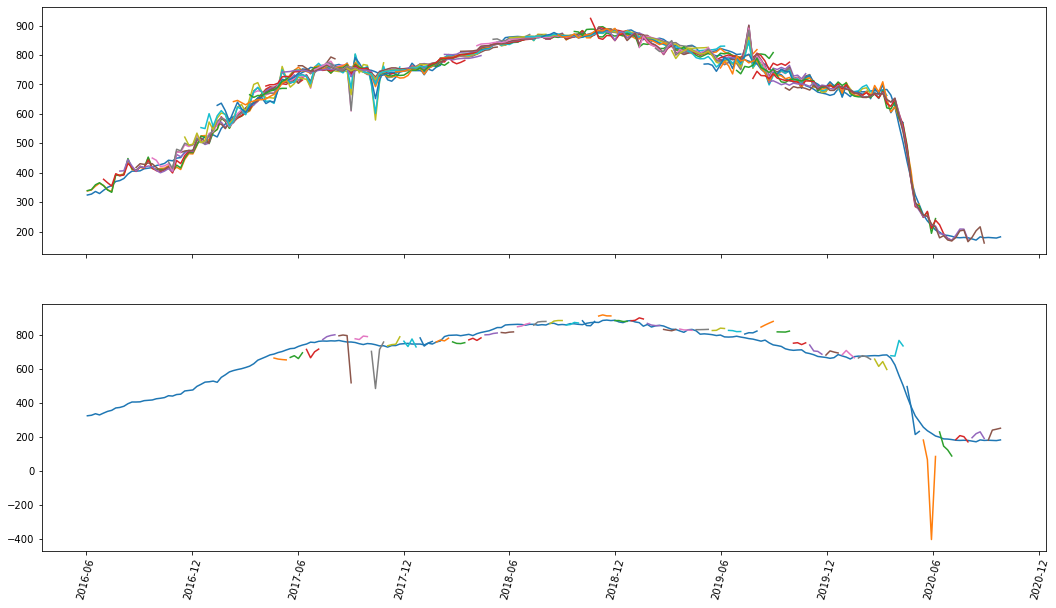

(18.9074054436378,
 0.8133447123237044,
 14.440313914674306,
 47.23832231971332,
 -95.61035358389113,
 40.490605803535004)

In [26]:
alpha_best = alpha_score.alpha[alpha_score.index[0]]
model = Lasso(alpha=alpha_best)
pipe = make_pipeline(scaler,model)

lasso_alpha = plot_model(date,X,y,cv,pipe)
add_model('lasso_alpha',lasso_alpha)

In [27]:
ak_score = pd.DataFrame(columns=['k','alpha','rmse_tr','r2_tr','mae_tr','rmse_tt','r2_tt','mae_tt'])

warnings.filterwarnings('ignore')

for i in range(1,X.shape[1]+1):
    feat_sel = SelectKBest(f_regression,k=i)
    
    for j in np.arange(0.01,1,step=0.005):
        model = Lasso(alpha=j)
        pipe = make_pipeline(scaler,feat_sel,model)
  
        rmse_tr, r2_tr, mae_tr, rmse_tt, r2_tt, mae_tt = plot_model(date,X,y,cv,pipe,plot=False)
        
        new_row = {
            'k':i,
            'alpha':j,
            'rmse_tr':rmse_tr,
            'r2_tr':r2_tr,
            'mae_tr':mae_tr, 
            'rmse_tt':rmse_tt,
            'r2_tt':r2_tt,
            'mae_tt':mae_tt, 
        }
        
        ak_score = ak_score.append(new_row,ignore_index=True)

warnings.filterwarnings('default')    
    
ak_score.sort_values(by='rmse_tt',inplace=True)
ak_score.head()

,k,alpha,rmse_tr,r2_tr,mae_tr,rmse_tt,r2_tt,mae_tt
396,3.0,0.010,24.812530,0.723750,18.323239,45.876511,-132.843253,40.957689
397,3.0,0.015,24.817889,0.723269,18.329727,45.895850,-132.017915,40.985390
398,3.0,0.020,24.823503,0.722784,18.336537,45.918493,-131.551946,41.016349
399,3.0,0.025,24.829397,0.722291,18.343471,45.942223,-131.437068,41.048098
400,3.0,0.030,24.835589,0.721789,18.350629,45.966419,-131.694775,41.080158


C:\Users\bryan\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8350.955271613137, tolerance: 49.44037391304349
  model = cd_fast.enet_coordinate_descent(
C:\Users\bryan\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15155.37189499929, tolerance: 67.657248
  model = cd_fast.enet_coordinate_descent(
C:\Users\bryan\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4164.54204195204, tolerance: 73.44319999999999
  model = cd_fast.enet_coordinate_descent(
C:\Users\bryan\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Object

C:\Users\bryan\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
C:\Users\bryan\Anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\bryan\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


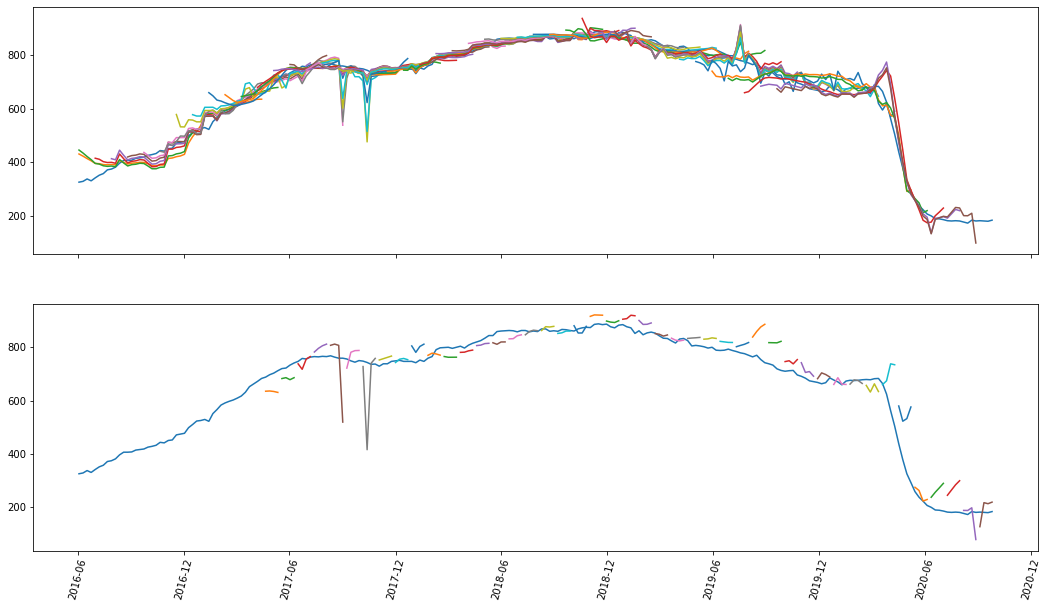

(24.81253014463861,
 0.7237496201093249,
 18.323238888709795,
 45.87651080379591,
 -132.84325250307944,
 40.95768904253582)

In [28]:
alpha_best = ak_score.alpha[ak_score.index[0]]
k_best = int(ak_score.k[ak_score.index[0]])

model = Lasso(alpha=alpha_best)
feat_sel = SelectKBest(f_regression,k=k_best)
pipe = make_pipeline(scaler,feat_sel,model)

lasso_ak = plot_model(date,X,y,cv,pipe)
add_model('lasso_ak',lasso_ak)

In [29]:
print(pd.Series(model.coef_, index=X.columns[feat_sel.get_support()]).sort_values(ascending=False))

usa_l48_prod__abs_energy        93.801004
opec_surp_capac__abs_energy     69.993685
opec_surp_capac               -202.697418
dtype: float64


### ElasticNet Regression 
Baseline model will be a default ElasticNet regression

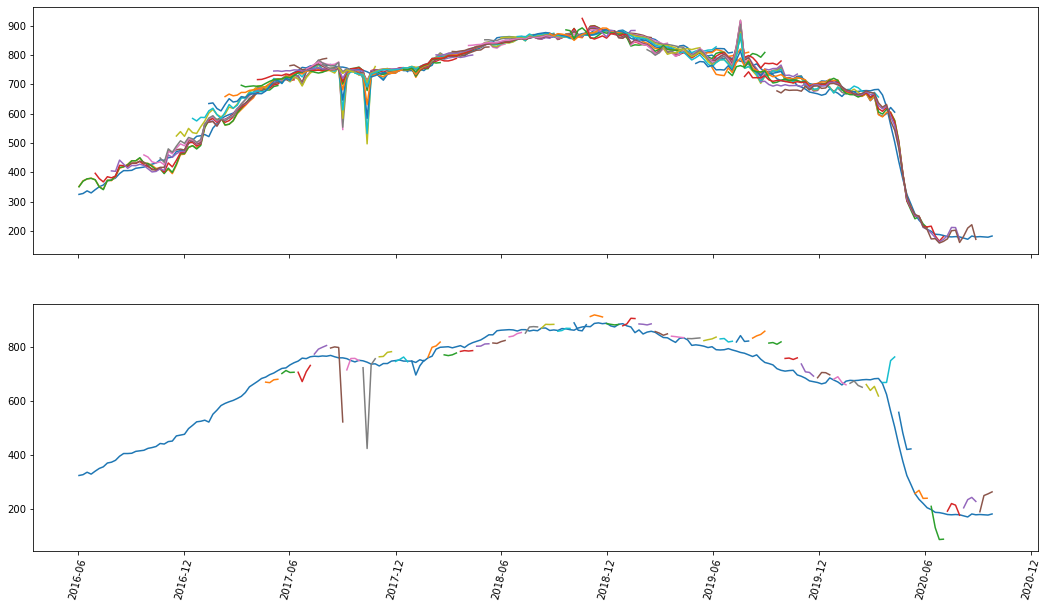

(21.991403717714423,
 0.7386638076654689,
 15.843550732234146,
 41.1629297142026,
 -68.8929294375937,
 35.78703343036986)

In [30]:
model = ElasticNet()
pipe = make_pipeline(scaler,model)

elastic_base = plot_model(date,X,y,cv,model)
add_model('elastic_base',elastic_base)

In [31]:
alpha_score = pd.DataFrame(columns=['alpha','rmse_tr','r2_tr','mae_tr','rmse_tt','r2_tt','mae_tt'])

warnings.filterwarnings('ignore')

for j in np.arange(0.001,0.1,step=0.0005):
    model = ElasticNet(alpha=j)
    pipe = make_pipeline(scaler,model)
  
    rmse_tr, r2_tr, mae_tr, rmse_tt, r2_tt, mae_tt = plot_model(date,X,y,cv,pipe,plot=False)
        
    new_row = {
        'alpha':j,
        'rmse_tr':rmse_tr,
        'r2_tr':r2_tr,
        'mae_tr':mae_tr, 
        'rmse_tt':rmse_tt,
        'r2_tt':r2_tt,
        'mae_tt':mae_tt, 
    }

    alpha_score = alpha_score.append(new_row,ignore_index=True)

warnings.filterwarnings('default')   
    
alpha_score.sort_values(by='rmse_tt',inplace=True)
alpha_score.head()

,alpha,rmse_tr,r2_tr,mae_tr,rmse_tt,r2_tt,mae_tt
197,0.0995,18.363681,0.849907,14.143812,47.662894,-165.441351,40.793212
196,0.0990,18.359029,0.850017,14.140013,47.670244,-165.866650,40.796659
195,0.0985,18.354375,0.850127,14.136198,47.678399,-166.287315,40.800785
194,0.0980,18.349732,0.850237,14.132378,47.686701,-166.702435,40.804973
193,0.0975,18.345142,0.850346,14.128643,47.694980,-167.110876,40.809140


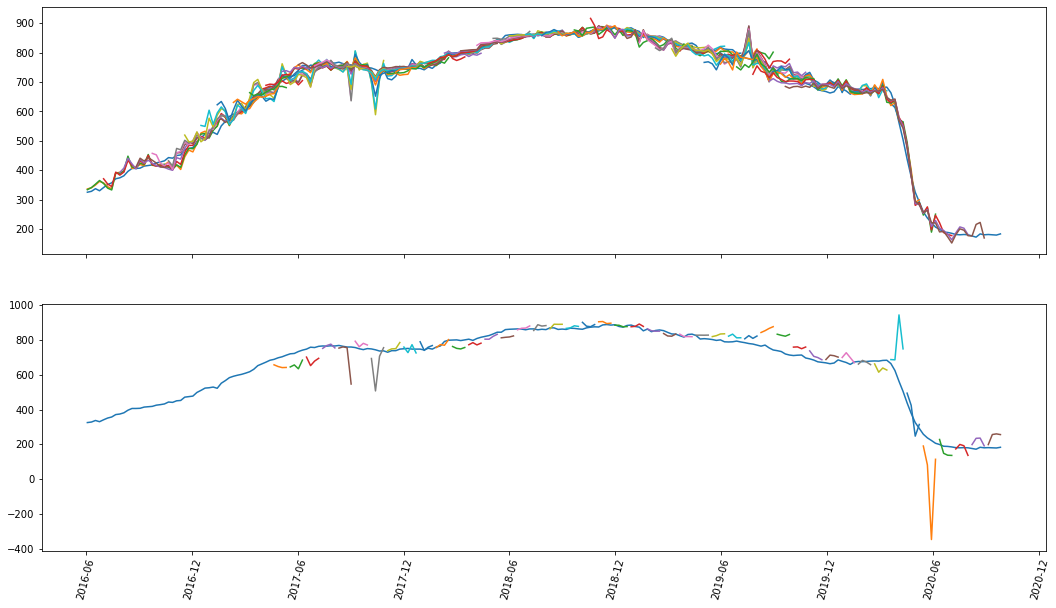

(18.363681309521862,
 0.8499070745583527,
 14.14381151530467,
 47.66289438506926,
 -165.4413514266283,
 40.7932116233808)

In [32]:
alpha_best = alpha_score.alpha[alpha_score.index[0]]
model = ElasticNet(alpha=alpha_best)
pipe = make_pipeline(scaler,model)

elastic_alpha = plot_model(date,X,y,cv,pipe)
add_model('elastic_alpha',elastic_alpha)

In [33]:
ak_score = pd.DataFrame(columns=['k','alpha','rmse_tr','r2_tr','mae_tr','rmse_tt','r2_tt','mae_tt'])

warnings.filterwarnings('ignore')

for i in range(2,X.shape[1]+1):
    feat_sel = SelectKBest(f_regression,k=i)
    
    for j in np.arange(0.001,0.2,step=0.001):
        model = ElasticNet(alpha=j)
        pipe = make_pipeline(scaler,feat_sel,model)
  
        rmse_tr, r2_tr, mae_tr, rmse_tt, r2_tt, mae_tt = plot_model(date,X,y,cv,pipe,plot=False)
        
        new_row = {
            'k':i,
            'alpha':j,
            'rmse_tr':rmse_tr,
            'r2_tr':r2_tr,
            'mae_tr':mae_tr, 
            'rmse_tt':rmse_tt,
            'r2_tt':r2_tt,
            'mae_tt':mae_tt, 
        }
        
        ak_score = ak_score.append(new_row,ignore_index=True)

warnings.filterwarnings('default')    
    
ak_score.sort_values(by='rmse_tt',inplace=True)
ak_score.head()

,k,alpha,rmse_tr,r2_tr,mae_tr,rmse_tt,r2_tt,mae_tt
199,3.0,0.001,24.875287,0.721261,18.393928,45.964829,-128.917756,41.138977
200,3.0,0.002,24.932361,0.718634,18.455478,46.048698,-129.026964,41.298119
201,3.0,0.003,24.975912,0.716600,18.501121,46.108419,-132.657974,41.414949
202,3.0,0.004,25.010368,0.714960,18.537505,46.152277,-139.249490,41.506571
203,3.0,0.005,25.038855,0.713579,18.567027,46.188488,-148.791733,41.579917


C:\Users\bryan\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29405.686076512662, tolerance: 49.44037391304349
  model = cd_fast.enet_coordinate_descent(
C:\Users\bryan\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34701.97690601401, tolerance: 67.657248
  model = cd_fast.enet_coordinate_descent(
C:\Users\bryan\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13252.488947764876, tolerance: 73.44319999999999
  model = cd_fast.enet_coordinate_descent(
C:\Users\bryan\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Obj

C:\Users\bryan\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
C:\Users\bryan\Anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\bryan\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
C:\Users\bryan\Anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\bryan\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
C:\Users\bryan\Anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:302: RuntimeWarning: invalid value encountered i

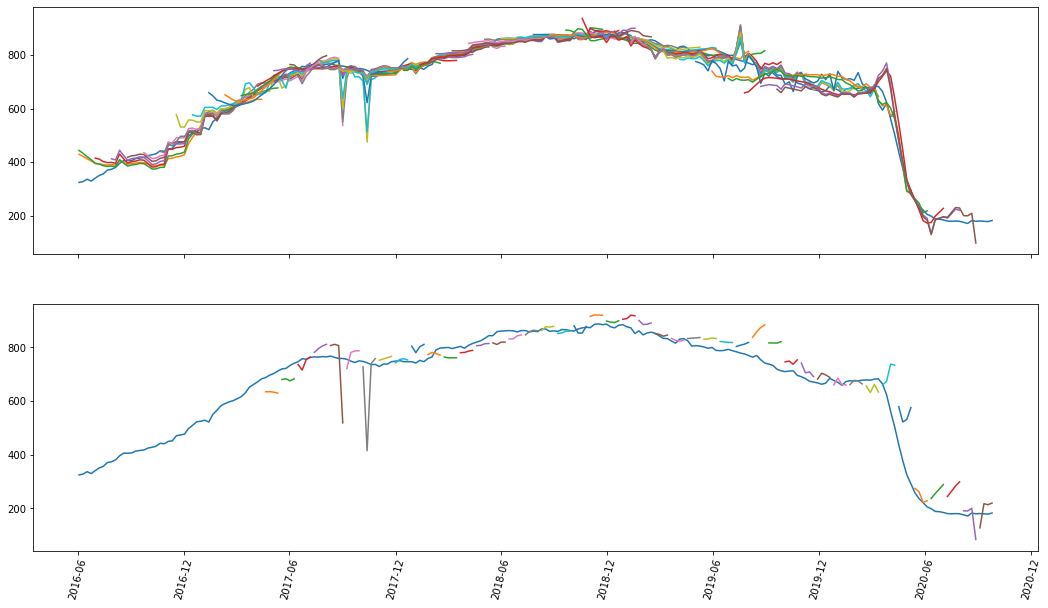

(24.875286519825554,
 0.721261322477396,
 18.39392849943604,
 45.96482898545578,
 -128.91775640664656,
 41.13897712951657)

In [34]:
alpha_best = ak_score.alpha[ak_score.index[0]]
k_best = int(ak_score.k[ak_score.index[0]])

model = ElasticNet(alpha=alpha_best)
feat_sel = SelectKBest(f_regression,k=k_best)
pipe = make_pipeline(scaler,feat_sel,model)

elastic_ak = plot_model(date,X,y,cv,pipe)
add_model('elastic_ak',elastic_ak)

### Random Forest Regression 
Baseline model will be a default RF regression

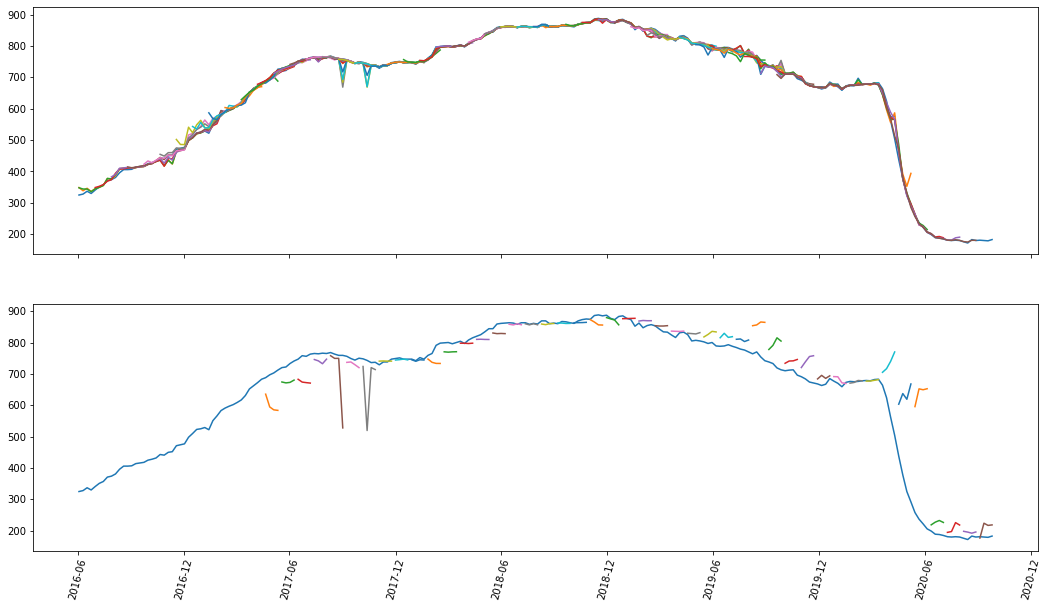

(7.03658998116568,
 0.9825611569796968,
 4.177878260869566,
 48.98757196506464,
 -386.09991468147814,
 44.6396111111111)

In [35]:
model = RandomForestRegressor(random_state=42)

pipe = make_pipeline(scaler,model)

rand_base = plot_model(date,X,y,cv,model)
add_model('rand_base',rand_base)

In [36]:
est_score = pd.DataFrame(columns=['n_estimators','rmse_tr','r2_tr','mae_tr','rmse_tt','r2_tt','mae_tt'])

for n in np.arange(1,100,step=1):
    model = RandomForestRegressor(n_estimators = n)
    pipe = make_pipeline(scaler,model)
  
    rmse_tr, r2_tr, mae_tr, rmse_tt, r2_tt, mae_tt = plot_model(date,X,y,cv,pipe,plot=False)
    
    new_row = {
        'n_estimators':n,
        'rmse_tr':rmse_tr,
        'r2_tr':r2_tr,
        'mae_tr':mae_tr, 
        'rmse_tt':rmse_tt,
        'r2_tt':r2_tt,
        'mae_tt':mae_tt, 
    }
        
    est_score = est_score.append(new_row,ignore_index=True)
        
est_score.sort_values(by='rmse_tt',inplace=True)
est_score.head()

,n_estimators,rmse_tr,r2_tr,mae_tr,rmse_tt,r2_tt,mae_tt
1,2.0,13.443118,0.941292,6.039295,40.946444,-94.018638,36.372222
13,14.0,8.455219,0.974819,4.837830,44.975608,-705.114443,40.534921
11,12.0,8.586064,0.974471,4.873795,45.501324,-3012.415880,40.876852
4,5.0,9.871775,0.966991,5.433480,46.093760,-53.865920,41.135556
10,11.0,8.760992,0.973793,4.875505,46.418655,-704.347868,41.915152


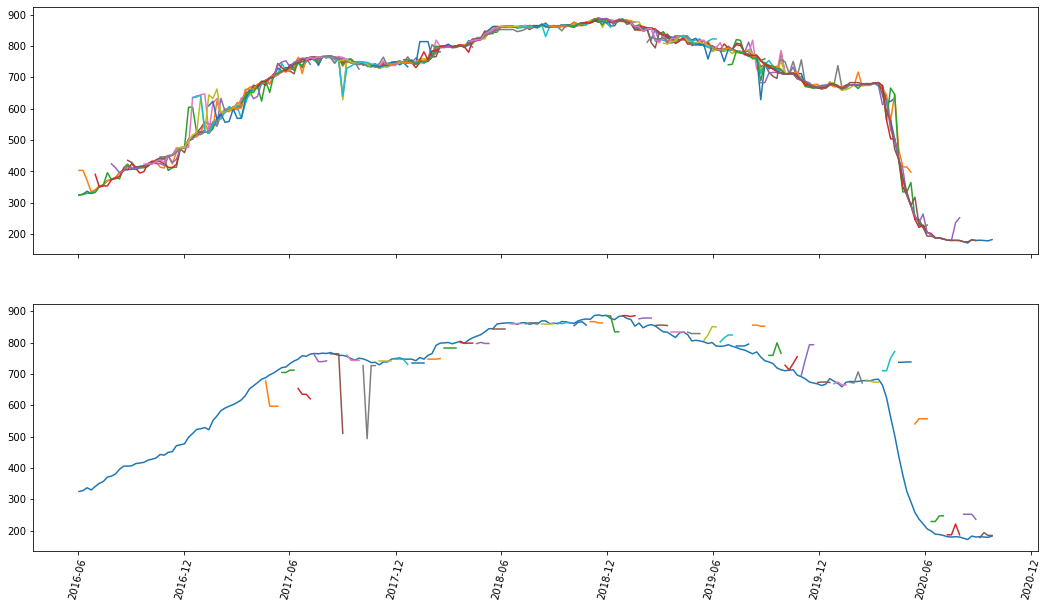

(13.735449049021385,
 0.9356522591912934,
 6.468541062801932,
 49.82548616771981,
 -13277.578368636088,
 44.33611111111111)

In [37]:
est_best = int(est_score.n_estimators[est_score.index[0]])

model = RandomForestRegressor(n_estimators = est_best)
pipe = make_pipeline(scaler,model)

rand_est = plot_model(date,X,y,cv,pipe)
add_model('rand_est',rand_est)

In [38]:
est_score = pd.DataFrame(columns=['k','n_estimate','rmse_tr','r2_tr','mae_tr','rmse_tt','r2_tt','mae_tt'])

warnings.filterwarnings('ignore')

for i in range(1,X.shape[1]+1):
    feat_sel = SelectKBest(f_regression,k=i)
    
    for n in np.arange(1,100,step=1):
        model = RandomForestRegressor(n_estimators = n)
        pipe = make_pipeline(scaler,feat_sel,model)

        rmse_tr, r2_tr, mae_tr, rmse_tt, r2_tt, mae_tt = plot_model(date,X,y,cv,pipe,plot=False)

        new_row = {
            'k':i,
            'n_estimate':n,
            'rmse_tr':rmse_tr,
            'r2_tr':r2_tr,
            'mae_tr':mae_tr, 
            'rmse_tt':rmse_tt,
            'r2_tt':r2_tt,
            'mae_tt':mae_tt, 
        }

        est_score = est_score.append(new_row,ignore_index=True)

warnings.filterwarnings('default')    
    
est_score.sort_values(by='rmse_tt',inplace=True)
est_score.head()

,k,n_estimate,rmse_tr,r2_tr,mae_tr,rmse_tt,r2_tt,mae_tt
198,3.0,1.0,16.307115,0.912458,6.524669,34.309259,-19.195611,28.311111
594,7.0,1.0,19.980158,0.898135,7.177623,38.105679,-44.025805,32.383333
793,9.0,2.0,13.256577,0.939993,5.982860,39.702125,-208.830035,34.394444
203,3.0,6.0,10.286108,0.967031,5.780267,39.752164,-1396.715197,35.278704
221,3.0,24.0,8.405335,0.976552,5.126016,40.251354,-604.331232,35.509306


C:\Users\bryan\Anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\bryan\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
C:\Users\bryan\Anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\bryan\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
C:\Users\bryan\Anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\bryan\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_eq

C:\Users\bryan\Anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\bryan\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


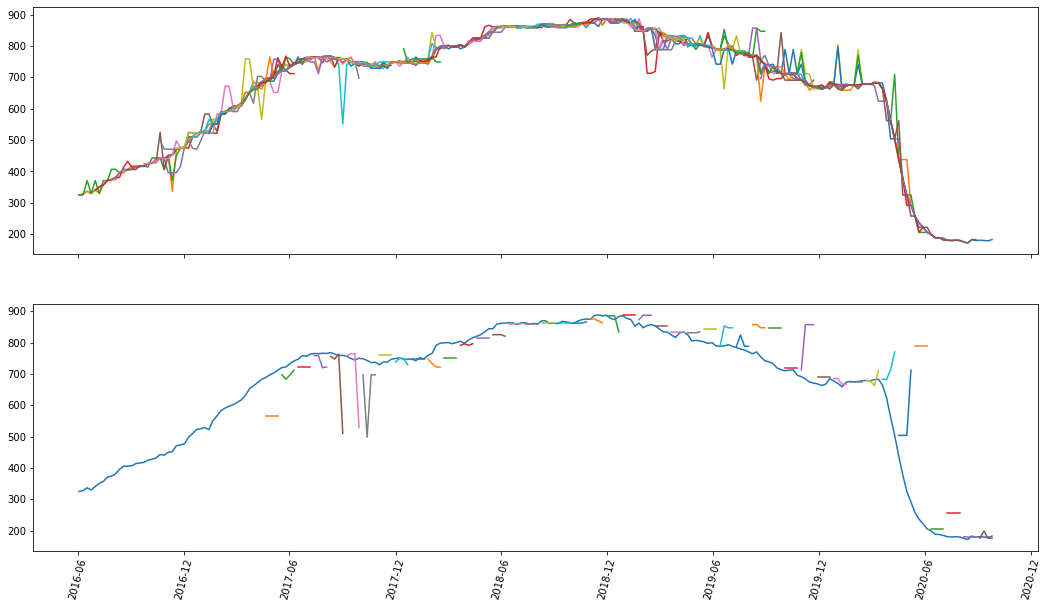

(15.201111216084133,
 0.911081796417942,
 5.993526570048309,
 57.529089996116326,
 -27.11308956599451,
 50.81111111111111)

In [39]:
est_best = int(est_score.n_estimate[est_score.index[0]])

model = RandomForestRegressor(n_estimators = est_best)
pipe = make_pipeline(scaler,feat_sel,model)

rand_nk = plot_model(date,X,y,cv,pipe)
add_model('rand_nk',rand_nk)

### XGBoost Regression 
Baseline model will be using default parameters

<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject


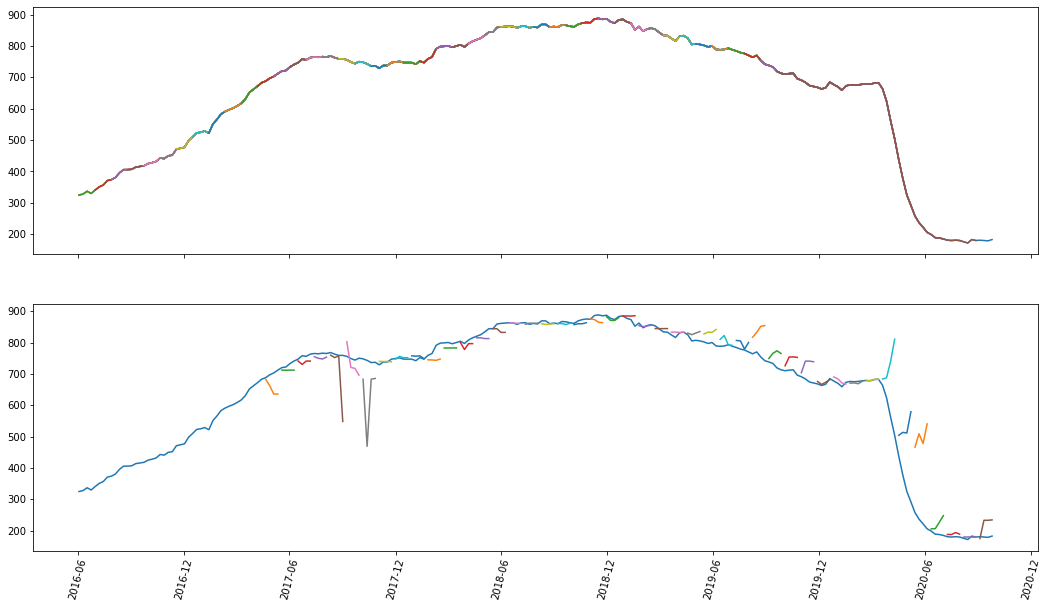

(0.0009315855122548169,
 0.999999999424684,
 0.0006775925493470713,
 37.93110782651394,
 -1234.080242668613,
 32.86487240261502)

In [44]:
import xgboost as xgb

model = xgb.XGBRegressor()
pipe = make_pipeline(scaler, model)

xgb_base = plot_model(date,X,y,cv,pipe)
add_model('xgb_base',xgb_base)

In [47]:
xgb_score = pd.DataFrame(columns=['learn_rate','gamma','lambda','alpha','rmse_tr','r2_tr','mae_tr','rmse_tt','r2_tt','mae_tt'])

# eta [0,1], gamma [0, inf] , lambda [0, inf], nrounds [def = 100]
eta = np.arange(0,1,step = 0.2)

# gamma [0, inf]
gamma = [0,0.1,1,10,100]

# lambda [0, inf]
reg_lambda = [0,0.1,1,10,100]

# alpha [def = 1]
reg_alpha = [0,0.1,1,10,100]

# nrounds [def = 100]
nrounds = [10,100,1000]

for e in eta:
    for g in gamma:
        for l in reg_lambda:
            for a in reg_alpha:
                model = xgb.XGBRegressor(eta=e, gamma=g,reg_lambda=l,reg_alpha=a)
                pipe = make_pipeline(scaler,model)

                rmse_tr, r2_tr, mae_tr, rmse_tt, r2_tt, mae_tt = plot_model(date,X,y,cv,pipe,plot=False)

                new_row = {
                    'learn_rate':e,
                    'gamma':g,
                    'lambda':l,
                    'alpha':a,
                    #'nrounds':n,
                    'rmse_tr':rmse_tr,
                    'r2_tr':r2_tr,
                    'mae_tr':mae_tr, 
                    'rmse_tt':rmse_tt,
                    'r2_tt':r2_tt,
                    'mae_tt':mae_tt, 
                }

                xgb_score = xgb_score.append(new_row,ignore_index=True)

In [48]:
xgb_score.sort_values(by='rmse_tt',inplace=True)
xgb_score.head()

,learn_rate,gamma,lambda,alpha,rmse_tr,r2_tr,mae_tr,rmse_tt,r2_tt,mae_tt
265,0.4,0.0,10.0,0.0,0.162143,0.999991,0.055475,36.040956,-392.306817,30.420699
292,0.4,0.1,10.0,1.0,0.565445,0.999824,0.344493,36.182744,-1525.249467,30.625222
266,0.4,0.0,10.0,0.1,0.185227,0.999988,0.071314,36.196452,-1027.220574,30.545160
267,0.4,0.0,10.0,1.0,0.383907,0.999934,0.195760,36.225690,-685.134418,30.654791
290,0.4,0.1,10.0,0.0,0.338823,0.999939,0.205210,36.245247,-824.093451,30.621849


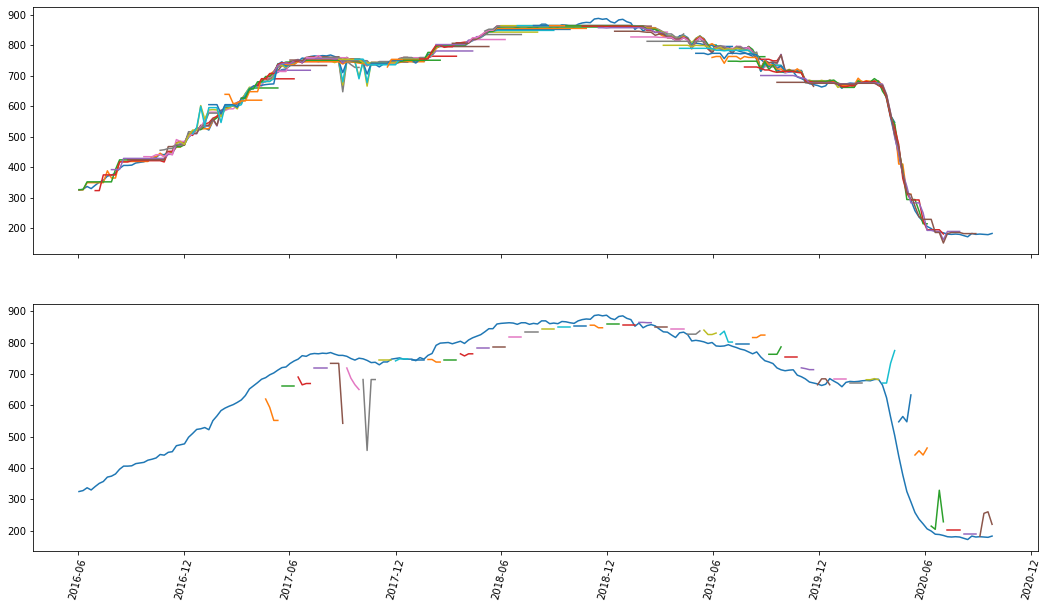

(14.349388020618663,
 0.8384757084622778,
 10.277803844212334,
 51.110297357065285,
 -48.86488367008961,
 46.50713984171549)

In [51]:
i = 2

alpha_best = int(xgb_score.alpha[xgb_score.index[i]])
gamma_best = int(xgb_score.gamma[xgb_score.index[i]])
lambda_best = int(xgb_score['lambda'][xgb_score.index[i]])
learn_rate_best = int(xgb_score.learn_rate[xgb_score.index[i]])

model = xgb.XGBRegressor(eta=learn_rate_best, gamma=gamma_best,reg_lambda=lambda_best,reg_alpha=alpha_best)

xgb_opt = plot_model(date,X,y,cv,pipe)
add_model('xgb_opt',xgb_opt)

In [43]:
model_score.sort_values(by='rmse_tt')

,model,rmse_tr,r2_tr,mae_tr,rmse_tt,r2_tt,mae_tt
6,lasso_base,20.571569,0.809818,15.175058,39.834874,-54.703507,34.674652
9,elastic_base,21.991404,0.738664,15.843551,41.162930,-68.892929,35.787033
2,linear_kbest,24.737043,0.728074,18.228015,45.828265,-143.691569,40.815190
8,lasso_ak,24.812530,0.723750,18.323239,45.876511,-132.843253,40.957689
11,elastic_ak,24.875287,0.721261,18.393928,45.964829,-128.917756,41.138977
5,ridge_ak,25.008176,0.715123,18.535819,46.151488,-137.725315,41.504115
7,lasso_alpha,18.907405,0.813345,14.440314,47.238322,-95.610354,40.490606
10,elastic_alpha,18.363681,0.849907,14.143812,47.662894,-165.441351,40.793212
12,rand_base,7.036590,0.982561,4.177878,48.987572,-386.099915,44.639611
13,rand_est,13.735449,0.935652,6.468541,49.825486,-13277.578369,44.336111
